# Семинар 4 — Разработка RNN модели и решение задачи NER

-----

### **Цель семинара**

На этом семинаре мы реализуем **Bi-LSTM** и **Bi-LSTM + CRF** подходы, обучим модели для задачи **Named Entity Recognition (NER)** и сравним производительность различных архитектур.

**После семинара вы будете:**
- Уметь решать задачу NER с помощью рекуррентных сетей
- Взгляните на BIO разметку для задачи NER
- Использовать Bi-LSTM и CRF слой для маркировки последовательностей (sequence labeling)

-----

### **0. Установка и импорт библиотек**

In [ ]:
!pip install fasttext
!pip install huggingface_hub
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=35360dab070fddc1e55a8735f007dc9d38a02b9aa0e19fc6e9303b8b4376fa9e
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
# Загрузка необходимой библиотеки
from datasets import load_dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from collections import Counter
from huggingface_hub import hf_hub_download
import fasttext

from sklearn.metrics import confusion_matrix
from seqeval.metrics import classification_report


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings("ignore")
print('CUDA ?: ', torch.cuda.is_available())

CUDA ?:  True


-----

### **1. Подготовка данных для NER**

Загрузим датасет для задачи NER в формате BIO (Begin-Inside-Outside).

Дополнительно загрузим предобученную FastText модель

In [ ]:
# Словарь для ID тегов
tag_mapper = {
    0: 'O', 1: 'I-AGE', 2: 'B-AGE', 3: 'B-AWARD', 4: 'I-AWARD', 5: 'B-CITY', 6: 'I-CITY',
    7: 'B-COUNTRY', 8: 'I-COUNTRY', 9: 'B-CRIME', 10: 'I-CRIME', 11: 'B-DATE', 12: 'I-DATE',
    13: 'B-DISEASE', 14: 'I-DISEASE', 15: 'B-DISTRICT', 16: 'I-DISTRICT', 17: 'B-EVENT',
    18: 'I-EVENT', 19: 'B-FACILITY', 20: 'I-FACILITY', 21: 'B-FAMILY', 22: 'I-FAMILY',
    23: 'B-IDEOLOGY', 24: 'I-IDEOLOGY', 25: 'B-LANGUAGE', 26: 'I-LAW', 27: 'B-LAW',
    28: 'B-LOCATION', 29: 'I-LOCATION', 30: 'B-MONEY', 31: 'I-MONEY', 32: 'B-NATIONALITY',
    33: 'I-NATIONALITY', 34: 'B-NUMBER', 35: 'I-NUMBER', 36: 'B-ORDINAL', 37: 'I-ORDINAL',
    38: 'B-ORGANIZATION', 39: 'I-ORGANIZATION', 40: 'B-PENALTY', 41: 'I-PENALTY',
    42: 'B-PERCENT', 43: 'I-PERCENT', 44: 'B-PERSON', 45: 'I-PERSON', 46: 'I-PRODUCT',
    47: 'B-PRODUCT', 48: 'B-PROFESSION', 49: 'I-PROFESSION', 50: 'B-RELIGION',
    51: 'I-RELIGION', 52: 'B-STATE_OR_PROVINCE', 53: 'I-STATE_OR_PROVINCE',
    54: 'B-TIME', 55: 'I-TIME', 56: 'B-WORK_OF_ART', 57: 'I-WORK_OF_ART'
}

def convert_dataset_format(dataset_split):
    formatted_data = []
    for item in dataset_split:
        if not item['sequences']: continue
        words, tag_ids = item['sequences'], item['ids']
        formatted_data.append([(word, tag_mapper[tag_id]) for word, tag_id in zip(words, tag_ids)])
    return formatted_data

# Загружаем и преобразуем датасет
ds = load_dataset("surdan/nerel_short")
train_data = convert_dataset_format(ds['train'])
val_data = convert_dataset_format(ds['dev'])
test_data = convert_dataset_format(ds['test'])

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)} предложений")

# Создание словарей
class Vocabulary:
    def __init__(self):
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}

    def build_from_data(self, data):
        word_counts = Counter(word for sent in data for word, _ in sent)
        for word, count in word_counts.items():
            if word not in self.word2idx:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word
    def __len__(self): return len(self.word2idx)

class TagVocabulary:
    def __init__(self):
        self.tag2idx = {'<PAD>': 0}
        self.idx2tag = {0: '<PAD>'}

    def build_from_data(self, data):
        for sent in data:
            for _, tag in sent:
                if tag not in self.tag2idx:
                    idx = len(self.tag2idx)
                    self.tag2idx[tag] = idx
                    self.idx2tag[idx] = tag
    def __len__(self): return len(self.tag2idx)

word_vocab = Vocabulary()
word_vocab.build_from_data(train_data)
tag_vocab = TagVocabulary()
tag_vocab.build_from_data(train_data)

print(f"Размер словаря слов: {len(word_vocab)}")
print(f"Размер словаря тегов: {len(tag_vocab)}")

README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/924 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/435k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115k [00:00<?, ?B/s]

data/dev-00000-of-00001.parquet:   0%|          | 0.00/110k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2508 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/512 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/536 [00:00<?, ? examples/s]

Train: 2506, Val: 536, Test: 512 предложений
Размер словаря слов: 21613
Размер словаря тегов: 59


In [ ]:
print("Загрузка модели FastText...")
model_path = hf_hub_download(repo_id="facebook/fasttext-ru-vectors", filename="model.bin")
ft_model = fasttext.load_model(model_path)
embedding_dim = ft_model.get_dimension()
print(f"Модель загружена. Размерность: {embedding_dim}")

# Создаем матрицу эмбеддингов
embedding_matrix = np.zeros((len(word_vocab), embedding_dim))
for word, i in word_vocab.word2idx.items():
    vector = ft_model.get_word_vector(word)
    if vector is not None:
        embedding_matrix[i] = vector

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float)
print("Матрица эмбеддингов создана.")

Загрузка модели FastText...


model.bin:   0%|          | 0.00/7.26G [00:00<?, ?B/s]

Модель загружена. Размерность: 300
Матрица эмбеддингов создана.


-----

### **2. bi-LSTM модель для NER**


Создадим полную модель для задачи NER с использованием Bi-LSTM.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence


In [ ]:
class BiLSTM_NER(nn.Module):
    """Bi-LSTM модель для NER на предобученных эмбеддингах FastText"""

    def __init__(self, vocab_size, tag_size, embedding_dim, hidden_dim,
                 num_layers=2, dropout=0.3, embedding_matrix=None):
        super().__init__()

        # Слой эмбеддингов
        if embedding_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(
                embedding_matrix, freeze=True, padding_idx=0
            )
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Bi-LSTM слой
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim // 2,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True,
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout)
        # Выходной линейный слой
        self.hidden2tag = nn.Linear(hidden_dim, tag_size)

    def forward(self, words, lengths):
        batch_size, seq_len = words.shape

        embeds = self.embedding(words)
        embeds = self.dropout(embeds)

        # Упаковываем последовательности для обработки паддинга
        packed = pack_padded_sequence(embeds, lengths.cpu(), batch_first=True, enforce_sorted=True)

        lstm_out, _ = self.lstm(packed)

        # Распаковываем обратно
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True, total_length=seq_len)
        lstm_out = self.dropout(lstm_out)

        # Преобразуем выход LSTM в предсказания тегов
        emissions = self.hidden2tag(lstm_out)
        return emissions


class NERDataset(Dataset):
    def __init__(self, data, word_vocab, tag_vocab):
        self.data = data
        self.word_vocab = word_vocab
        self.tag_vocab = tag_vocab

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        sentence = self.data[idx]
        words = [word for word, _ in sentence]
        tags = [tag for _, tag in sentence]
        word_ids = [self.word_vocab.word2idx.get(w, self.word_vocab.word2idx['<UNK>']) for w in words]
        tag_ids = [self.tag_vocab.tag2idx[t] for t in tags]
        return torch.tensor(word_ids), torch.tensor(tag_ids), len(word_ids)

def collate_fn(batch):
    words, tags, lengths = zip(*batch)
    words_padded = pad_sequence(words, batch_first=True, padding_value=0)
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=0)

    lengths = torch.tensor(lengths)
    sorted_lengths, sorted_idx = lengths.sort(descending=True)

    return words_padded[sorted_idx], tags_padded[sorted_idx], sorted_lengths

In [ ]:
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for words, tags, lengths in tqdm(data_loader, desc="Training", leave=False):
        words, tags = words.to(device), tags.to(device)

        optimizer.zero_grad()

        outputs = model(words, lengths)
        # Игнорируем <PAD> теги при подсчете loss
        active_loss = tags.view(-1) != 0
        active_logits = outputs.view(-1, model.hidden2tag.out_features)[active_loss]
        active_labels = tags.view(-1)[active_loss]

        loss = criterion(active_logits, active_labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(data_loader)

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for words, tags, lengths in data_loader:
            words, tags = words.to(device), tags.to(device)

            outputs = model(words, lengths)

            active_loss = tags.view(-1) != 0
            active_logits = outputs.view(-1, model.hidden2tag.out_features)[active_loss]
            active_labels = tags.view(-1)[active_loss]

            loss = criterion(active_logits, active_labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=-1)
            for i in range(len(lengths)):
                length = lengths[i]
                all_preds.extend(preds[i, :length].cpu().numpy())
                all_labels.extend(tags[i, :length].cpu().numpy())

    # Вычисляем accuracy только по активным (не PAD) токенам
    accuracy = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_preds)
    return total_loss / len(data_loader), accuracy

# --- Основной цикл обучения ---
BATCH_SIZE = 32
train_loader = DataLoader(NERDataset(train_data, word_vocab, tag_vocab), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(NERDataset(val_data, word_vocab, tag_vocab), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

model = BiLSTM_NER(
    vocab_size=len(word_vocab),
    tag_size=len(tag_vocab),
    embedding_dim=embedding_dim,
    hidden_dim=256,
    embedding_matrix=embedding_matrix
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
num_epochs = 10

# Храним историю обучения
history = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': []
}
best_accuracy = 0
print("\nНачинаем обучение Bi-LSTM модели...")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Эпоха {epoch + 1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Accuracy: {val_acc:.4f}")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    scheduler.step(val_loss)

    # Сохраняем лучшую модель
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_ner_model.pt')
        print(f"  Новая лучшая модель сохранена! Accuracy: {best_accuracy:.4f}")


Начинаем обучение Bi-LSTM модели...


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 1/10 | Train Loss: 1.7629 | Val Loss: 1.6179 | Val Accuracy: 0.6096
  Новая лучшая модель сохранена! Accuracy: 0.6096


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 2/10 | Train Loss: 1.0366 | Val Loss: 1.3532 | Val Accuracy: 0.6365
  Новая лучшая модель сохранена! Accuracy: 0.6365


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 3/10 | Train Loss: 0.8013 | Val Loss: 1.3342 | Val Accuracy: 0.6496
  Новая лучшая модель сохранена! Accuracy: 0.6496


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 4/10 | Train Loss: 0.6848 | Val Loss: 1.2473 | Val Accuracy: 0.6626
  Новая лучшая модель сохранена! Accuracy: 0.6626


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 5/10 | Train Loss: 0.5982 | Val Loss: 1.2672 | Val Accuracy: 0.6716
  Новая лучшая модель сохранена! Accuracy: 0.6716


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 6/10 | Train Loss: 0.5285 | Val Loss: 1.2405 | Val Accuracy: 0.6824
  Новая лучшая модель сохранена! Accuracy: 0.6824


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 7/10 | Train Loss: 0.4876 | Val Loss: 1.2795 | Val Accuracy: 0.6855
  Новая лучшая модель сохранена! Accuracy: 0.6855


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 8/10 | Train Loss: 0.4348 | Val Loss: 1.3655 | Val Accuracy: 0.6844


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 9/10 | Train Loss: 0.4009 | Val Loss: 1.3784 | Val Accuracy: 0.6931
  Новая лучшая модель сохранена! Accuracy: 0.6931


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 10/10 | Train Loss: 0.3682 | Val Loss: 1.2377 | Val Accuracy: 0.7020
  Новая лучшая модель сохранена! Accuracy: 0.7020


-----

### **3. Оценка и анализ результатов**

Детально проанализируем результаты на тестовой выборке.

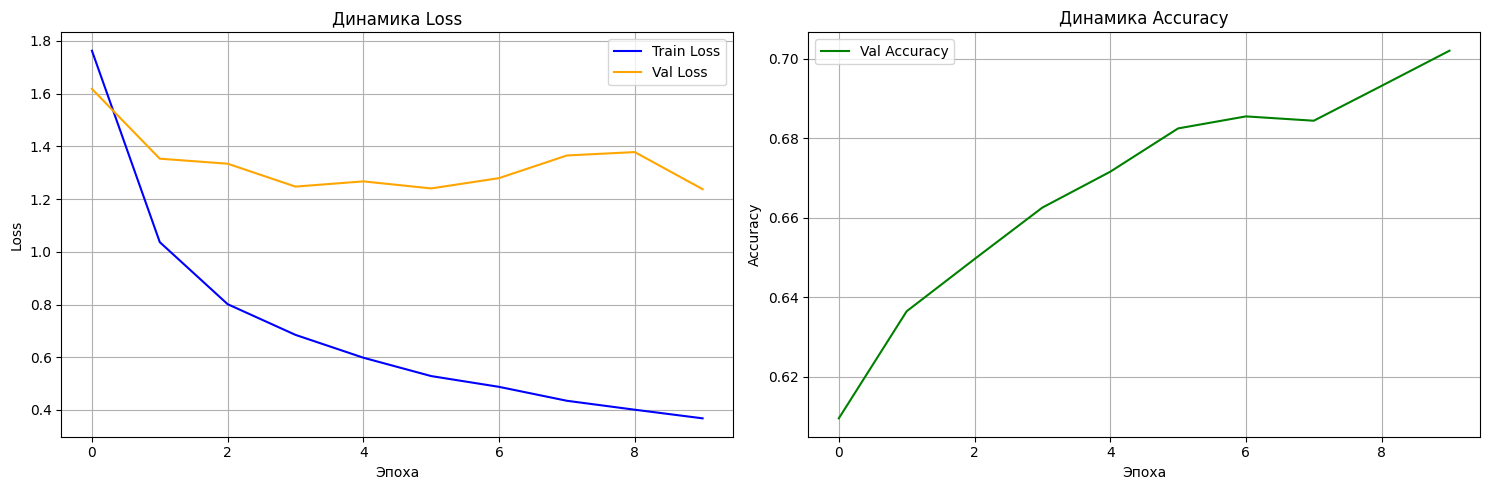

In [ ]:
# Создаем фигуру с двумя графиками
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# --- График 1: Loss ---
axes[0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0].set_title('Динамика Loss')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# --- График 2: Accuracy ---
axes[1].plot(history['val_acc'], label='Val Accuracy', color='green')
axes[1].set_title('Динамика Accuracy')
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

# Отображаем графики
plt.tight_layout()
plt.show()

In [ ]:
def evaluate_and_report(model, data_loader, tag_vocab, device):
    """
    Оценивает модель и выводит подробный отчет (precision/recall/F1).
    """
    model.eval()
    all_pred_tags = []
    all_true_tags = []

    with torch.no_grad():
        for words, tags, lengths in tqdm(data_loader, desc="Evaluating"):
            words, tags = words.to(device), tags.to(device)

            # Получаем предсказания модели
            outputs = model(words, lengths)
            predictions = outputs.argmax(dim=-1)

            # Собираем реальные и предсказанные теги, обрезая по реальной длине
            for i in range(len(lengths)):
                length = lengths[i]
                # Конвертируем ID тегов обратно в строки
                true_seq = [tag_vocab.idx2tag[t.item()] for t in tags[i, :length]]
                pred_seq = [tag_vocab.idx2tag[p.item()] for p in predictions[i, :length]]

                all_true_tags.append(true_seq)
                all_pred_tags.append(pred_seq)


    print("\n" + "="*50)
    print("Отчет классификации NER:")
    print("="*50)
    # Используем classification_report из библиотеки seqeval
    report = classification_report(all_true_tags, all_pred_tags, zero_division=0)
    print(report)

    flat_true = [tag for seq in all_true_tags for tag in seq]
    flat_pred = [tag for seq in all_pred_tags for tag in seq]

    return flat_true, flat_pred

# Загружаем лучшую сохраненную модель
model.load_state_dict(torch.load('best_ner_model.pt', map_location=device))

# Создаем DataLoader для тестовой выборки
test_loader = DataLoader(NERDataset(test_data, word_vocab, tag_vocab), batch_size=32, shuffle=False, collate_fn=collate_fn)

# Запускаем оценку
true_tags_flat, pred_tags_flat = evaluate_and_report(model, test_loader, tag_vocab, device)

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


Отчет классификации NER:
                   precision    recall  f1-score   support

              AGE       0.49      0.38      0.43        52
            AWARD       0.26      0.19      0.22        84
             CITY       0.81      0.26      0.40       174
          COUNTRY       0.77      0.78      0.78       338
            CRIME       0.17      0.08      0.11        24
             DATE       0.75      0.76      0.76       421
          DISEASE       0.00      0.00      0.00        46
         DISTRICT       0.00      0.00      0.00        16
            EVENT       0.54      0.38      0.45       549
         FACILITY       0.03      0.09      0.05        55
           FAMILY       0.00      0.00      0.00         7
         IDEOLOGY       0.60      0.21      0.32        28
         LANGUAGE       1.00      0.50      0.67         2
              LAW       0.26      0.21      0.23        42
         LOCATION       0.25      0.03      0.05        35
            MONEY       0.30 

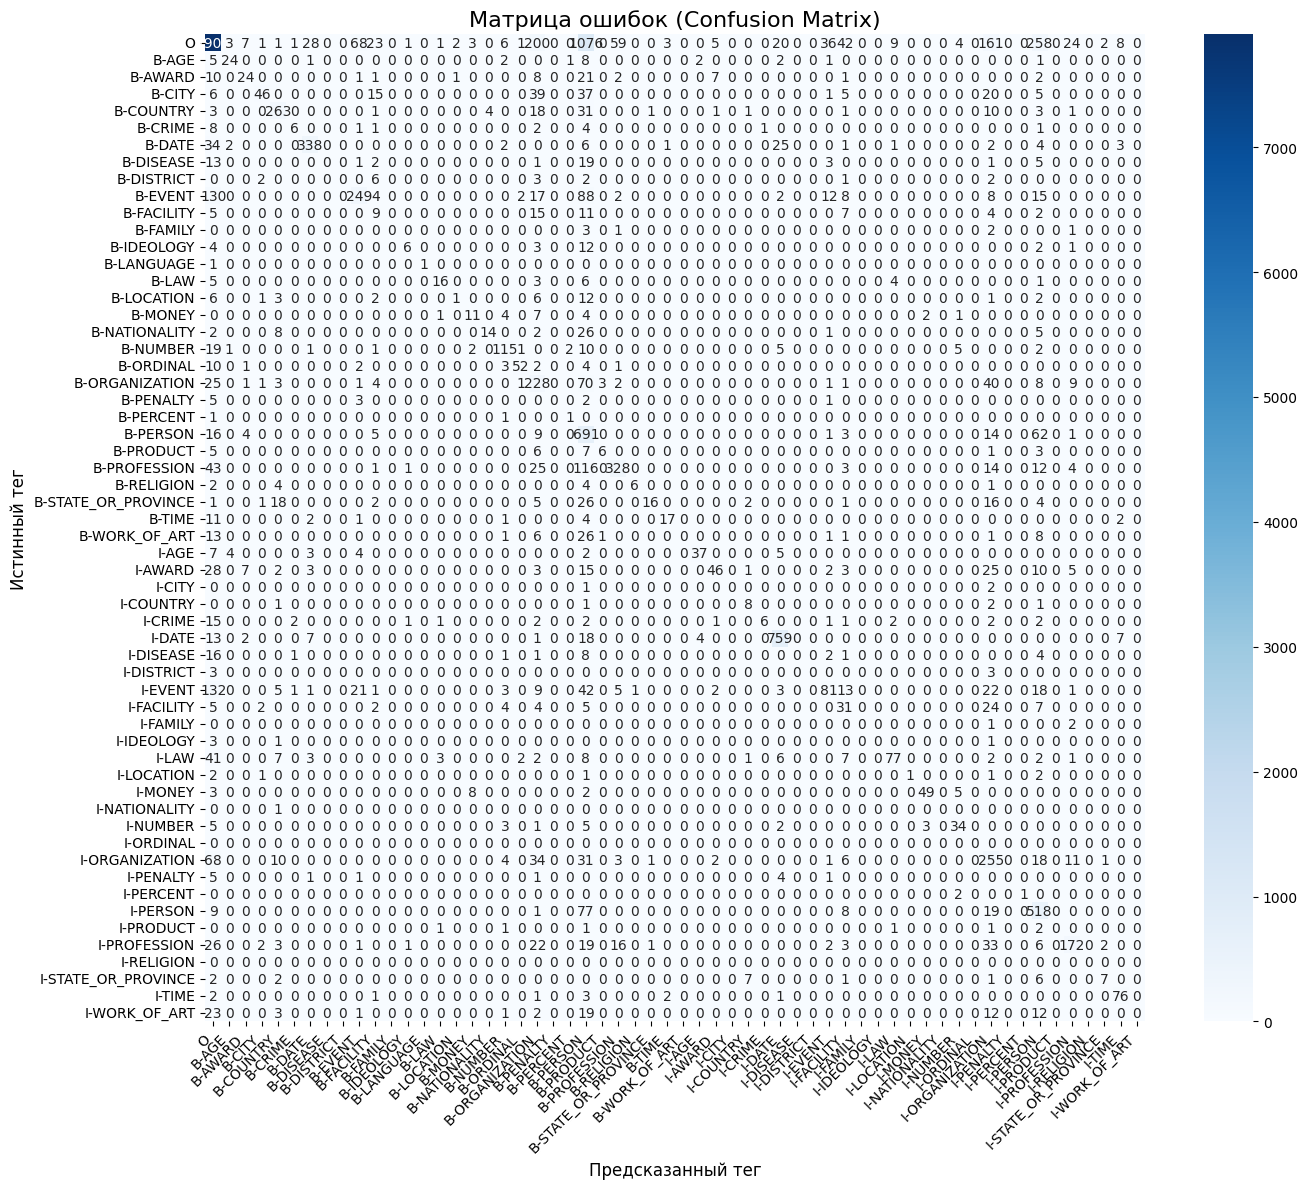

In [ ]:
# Получаем уникальные теги, исключая <PAD>
labels = sorted(
    list(tag_vocab.tag2idx.keys() - {'<PAD>'}),
    key=lambda x: (x[0] if x != 'O' else '', x[2:] if x != 'O' else '')
)

# Строим матрицу ошибок
cm = confusion_matrix(true_tags_flat, pred_tags_flat, labels=labels)

# Визуализация
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Матрица ошибок (Confusion Matrix)', fontsize=16)
plt.ylabel('Истинный тег', fontsize=12)
plt.xlabel('Предсказанный тег', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
def predict_tags(sentence, model, word_vocab, tag_vocab, device):
    """Предсказывает NER-теги для одного предложения."""
    model.eval()

    # Токенизация (простое разделение по пробелам)
    words = sentence.split()

    # Конвертация в тензор
    word_ids = [word_vocab.word2idx.get(w, word_vocab.word2idx['<UNK>']) for w in words]
    word_tensor = torch.tensor([word_ids], device=device)
    lengths = torch.tensor([len(word_ids)], device=device)

    with torch.no_grad():
        outputs = model(word_tensor, lengths)
        predictions = outputs.argmax(dim=-1)[0].cpu().numpy()

    # Конвертация ID в теги
    tags = [tag_vocab.idx2tag[idx] for idx in predictions]

    # Вывод результата
    print(f"Предложение: '{sentence}'")
    for word, tag in zip(words, tags):
        if tag != 'O':
            print(f"  {word:15} -> {tag}")
    print("-" * 30)


# --- Примеры использования ---
predict_tags("Президент России Владимир Путин прибыл в Москву", model, word_vocab, tag_vocab, device)
predict_tags("Корпорация Google анонсировала новый смартфон Pixel", model, word_vocab, tag_vocab, device)
predict_tags("Встреча пройдет в Санкт-Петербурге 25 декабря", model, word_vocab, tag_vocab, device)

Предложение: 'Президент России Владимир Путин прибыл в Москву'
  Президент       -> B-PROFESSION
  России          -> B-COUNTRY
  Владимир        -> B-PERSON
  Путин           -> I-PERSON
  прибыл          -> B-EVENT
  Москву          -> B-CITY
------------------------------
Предложение: 'Корпорация Google анонсировала новый смартфон Pixel'
  Корпорация      -> B-PERSON
  Google          -> B-ORGANIZATION
  анонсировала    -> B-PERSON
  Pixel           -> B-PERSON
------------------------------
Предложение: 'Встреча пройдет в Санкт-Петербурге 25 декабря'
  Встреча         -> B-PERSON
  Санкт-Петербурге -> B-ORGANIZATION
  25              -> B-DATE
  декабря         -> I-DATE
------------------------------


-----

### **4. bi-LSTM + CRF модель**

Добавим CRF модель на выходе.

In [ ]:
!pip install pytorch-crf

In [ ]:
from torchcrf import CRF

class BiLSTM_CRF(nn.Module):
    """
    Bi-LSTM модель для NER с CRF слоем.
    """
    def __init__(self, vocab_size, tag_size, embedding_dim, hidden_dim,
                 num_layers=2, dropout=0.3, embedding_matrix=None):
        super().__init__()

        # Слой эмбеддингов (аналогично предыдущей модели)
        if embedding_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(
                embedding_matrix, freeze=True, padding_idx=0
            )
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Bi-LSTM слой
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim // 2,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True,
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout)
        # Линейный слой, который преобразует выход LSTM в "эмиссии" для CRF
        self.hidden2tag = nn.Linear(hidden_dim, tag_size)

        # CRF слой
        self.crf = CRF(tag_size, batch_first=True)

    def _create_mask(self, lengths, max_len):
        """Создает маску для игнорирования паддинга в CRF."""
        mask = torch.arange(max_len, device=lengths.device).expand(len(lengths), max_len) < lengths.unsqueeze(1)
        return mask

    def forward(self, words, lengths, tags=None):
        """
        words: [batch_size, seq_len]
        lengths: длины последовательностей
        tags: [batch_size, seq_len] (для обучения)
        """
        batch_size, seq_len = words.shape

        embeds = self.embedding(words)
        embeds = self.dropout(embeds)

        # LSTM выход
        # Обратите внимание, что для pack_padded_sequence больше не нужно enforce_sorted=True
        # так как CRF этого не требует. Но сортировка в collate_fn все еще полезна для скорости.
        lstm_out, _ = self.lstm(embeds)
        lstm_out = self.dropout(lstm_out)

        # Получаем "эмиссии" - оценки для каждого тега в каждой позиции
        emissions = self.hidden2tag(lstm_out)

        # Создаем маску для CRF
        mask = self._create_mask(lengths, seq_len)

        if tags is not None:
            # Режим обучения: вычисляем log-likelihood loss
            # CRF слой возвращает отрицательный log-likelihood, поэтому берем с минусом
            loss = -self.crf(emissions, tags, mask=mask, reduction='mean')
            return loss
        else:
            # Режим инференса: декодируем лучшую последовательность тегов
            decoded_tags = self.crf.decode(emissions, mask=mask)
            return decoded_tags

In [ ]:
def train_epoch_crf(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for words, tags, lengths in tqdm(data_loader, desc="Training CRF", leave=False):
        words, tags, lengths = words.to(device), tags.to(device), lengths.to(device)

        optimizer.zero_grad()

        # Loss теперь вычисляется внутри модели
        loss = model(words, lengths, tags)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(data_loader)


def evaluate_and_report_crf(model, data_loader, tag_vocab, device):
    model.eval()
    all_pred_tags = []
    all_true_tags = []

    with torch.no_grad():
        for words, tags, lengths in tqdm(data_loader, desc="Evaluating CRF"):
            words, tags, lengths = words.to(device), tags.to(device), lengths.to(device)

            # Модель возвращает декодированную последовательность
            predictions = model(words, lengths)

            for i in range(len(lengths)):
                length = lengths[i]
                true_seq = [tag_vocab.idx2tag[t.item()] for t in tags[i, :length]]
                pred_seq = [tag_vocab.idx2tag[p] for p in predictions[i]]

                all_true_tags.append(true_seq)
                all_pred_tags.append(pred_seq)


    print("\n" + "="*50)
    print("CRF Model Classification Report:")
    print("="*50)
    report = classification_report(all_true_tags, all_pred_tags, zero_division=0)
    print(report)

In [ ]:
# Создаем DataLoader'ы
BATCH_SIZE = 32
train_loader = DataLoader(NERDataset(train_data, word_vocab, tag_vocab), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(NERDataset(val_data, word_vocab, tag_vocab), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(NERDataset(test_data, word_vocab, tag_vocab), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Создаем модель
model_crf = BiLSTM_CRF(
    vocab_size=len(word_vocab),
    tag_size=len(tag_vocab),
    embedding_dim=embedding_dim,  # Размерность из FastText
    hidden_dim=256,
    embedding_matrix=embedding_matrix
).to(device)

optimizer_crf = optim.Adam(model_crf.parameters(), lr=0.005)
num_epochs = 10

print("Начинаем обучение Bi-LSTM+CRF модели...")
for epoch in range(num_epochs):
    train_loss = train_epoch_crf(model_crf, train_loader, optimizer_crf, device)
    print(f"Эпоха {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f}")




Начинаем обучение Bi-LSTM+CRF модели...


Training CRF:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 1/10 | Train Loss: 51.0677


Training CRF:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 2/10 | Train Loss: 26.4327


Training CRF:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 3/10 | Train Loss: 19.0940


Training CRF:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 4/10 | Train Loss: 15.0166


Training CRF:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 5/10 | Train Loss: 12.6369


Training CRF:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 6/10 | Train Loss: 11.0456


Training CRF:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 7/10 | Train Loss: 9.7263


Training CRF:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 8/10 | Train Loss: 8.9088


Training CRF:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 9/10 | Train Loss: 8.0123


Training CRF:   0%|          | 0/79 [00:00<?, ?it/s]

Эпоха 10/10 | Train Loss: 7.2048


In [ ]:
print("\n--- Финальная оценка на тестовых данных ---")
evaluate_and_report_crf(model_crf, test_loader, tag_vocab, device)


--- Финальная оценка на тестовых данных ---


Evaluating CRF:   0%|          | 0/16 [00:00<?, ?it/s]


CRF Model Classification Report:
                   precision    recall  f1-score   support

              AGE       0.71      0.42      0.53        52
            AWARD       0.30      0.30      0.30        84
             CITY       0.73      0.26      0.39       174
          COUNTRY       0.82      0.75      0.78       338
            CRIME       0.46      0.25      0.32        24
             DATE       0.79      0.77      0.78       421
          DISEASE       0.00      0.00      0.00        46
         DISTRICT       0.00      0.00      0.00        16
            EVENT       0.66      0.35      0.46       549
         FACILITY       0.17      0.18      0.18        55
           FAMILY       0.00      0.00      0.00         7
         IDEOLOGY       0.67      0.21      0.32        28
         LANGUAGE       0.50      0.50      0.50         2
              LAW       0.39      0.29      0.33        42
         LOCATION       0.33      0.03      0.05        35
            MONEY    

In [ ]:
def predict_tags_crf(sentence, model, word_vocab, tag_vocab, device):
    """
    Предсказываем NER-теги для одного предложения с помощью нашей BiLSTM-CRF модели.
    """
    model.eval()

    # Токенизация (простое разделение по пробелам)
    words = sentence.split()
    if not words:
        print("Пустое предложение.")
        return

    # Конвертация в тензор
    word_ids = [word_vocab.word2idx.get(w, word_vocab.word2idx['<UNK>']) for w in words]
    word_tensor = torch.tensor([word_ids], device=device)
    lengths = torch.tensor([len(word_ids)], device=device)

    with torch.no_grad():
        predictions = model(word_tensor, lengths)[0]

    # Конвертация ID в теги
    tags = [tag_vocab.idx2tag[idx] for idx in predictions]

    # Вывод результата
    print(f"Предложение: '{sentence}'")
    for word, tag in zip(words, tags):
        # Выводим только слова с "непустыми" тегами для наглядности
        if tag != 'O':
            print(f"  {word:15} -> {tag}")
    print("-" * 30)


print("="*50)
print("Примеры предсказаний с моделью Bi-LSTM+CRF:")
print("="*50)

predict_tags_crf("Президент России Владимир Путин прибыл в Москву", model_crf, word_vocab, tag_vocab, device)
predict_tags_crf("Корпорация Google анонсировала новый смартфон Pixel", model_crf, word_vocab, tag_vocab, device)
predict_tags_crf("Встреча пройдет в Санкт-Петербурге 25 декабря", model_crf, word_vocab, tag_vocab, device)

Примеры предсказаний с моделью Bi-LSTM+CRF:
Предложение: 'Президент России Владимир Путин прибыл в Москву'
  Президент       -> B-PROFESSION
  России          -> B-COUNTRY
  Владимир        -> B-PERSON
  Путин           -> I-PERSON
  прибыл          -> B-EVENT
  Москву          -> B-CITY
------------------------------
Предложение: 'Корпорация Google анонсировала новый смартфон Pixel'
  Корпорация      -> B-PERSON
  Google          -> B-ORGANIZATION
  анонсировала    -> I-PERSON
  Pixel           -> B-ORGANIZATION
------------------------------
Предложение: 'Встреча пройдет в Санкт-Петербурге 25 декабря'
  Встреча         -> B-PERSON
  Санкт-Петербурге -> B-PERSON
  25              -> B-DATE
  декабря         -> I-DATE
------------------------------
